# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 100%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Experiment Analysis </strong> </p>


<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
This notebook contains analysis of experiment results. Most experiments consist of using testperanto to generate multiple datasets of artificial language. We then train pairwise on these subsets of these datasets, allowing to train while varying corpus length.
</p>


# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Table of Contents </strong> </p>


<table style="margin-left: auto; margin-right: auto; width: 85%; border-collapse: collapse; font-family: 'Georgia', serif; font-size: 105%; border: 2px solid #333;">
    <tr>
        <td>No</td>
        <td>Contents</td>
        <td>No</td>
        <td>Contents</td>
    </tr>
    <tr>
        <td>1</td>
        <td><a href="#1"> Basic Functionality</a></td>
        <td>4</td>
        <td><a href="#4">No Pronouns Analysis</a></td>
    </tr>
    <tr>
        <td>2</td>
        <td><a href="#2">SVO Permutation Analysis</a></td>
        <td>5</td>
        <td><a href="#5"> No Pronouns/Articles Analysis </a></td>
    </tr>
    <tr>
        <td>3</td>
        <td><a href="#3">Data Variability Analysis SVO Permutation Analysis</a></td>
        <td>6</td>
        <td><a href="#6">No Dependencies Analysis</a></td>
    </tr>
</table>


<a id='1'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Basic Functionality </strong> </p>


In [3]:
import os
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

import tensorflow as tf

from config import *
from helper import format_number

import warnings
warnings.filterwarnings("ignore")

2023-12-07 16:49:37.896303: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 16:49:37.951535: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 16:49:37.951565: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 16:49:37.951596: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 16:49:37.960808: I tensorflow/core/platform/cpu_feature_g

In [4]:
"""
get_data(exp_name) updates/fetches the data for assoc. experiment
"""

def get_data(exp_name='svo_perm'):
    """
    Returns pd.DataFrame with results associated with experiment exp_name

    exp_name should be either svo_perm or data_variability (for now)
    """
    if exp_name == "svo_perm":
        config = SVOConfig()
    
    elif exp_name == 'data_variability':
        config = VarConfig()
    
    elif exp_name == 'no_pro':
        config = NoProConfig()
    
    elif exp_name == 'no_dep':
        config = NoDepConfig()

    elif exp_name == 'no_pro1':
        config = NoPro1Config()

    else:
        raise ValueError(f"Experiment name must be svo_perm, data_variability, no_pro, no_pro1, no_dep")
    
    df_path = f'{config.EXP_PATH}/results.csv'

    try:
        df = pd.read_csv(df_path)
    
    except:
        print(f"{exp_name} hasn't been fully analyzed yet.")
   
    df['name']  = df['src'].str.lower() + "_" + df['tgt'].str.lower()
    df['is_id'] = ((df['src'] + "_id" == df['tgt']) | (df['src'] == df['tgt'] + '_id'))
    df['normalized_steps'] = df['num_steps'] / df['corpus_length'] # prop to num_epochs

    return df 

In [13]:
def plot_scores(df, score='bleu', selected_names=None):
    # group by name then find all corp_len, score pairs
    grouped = df.groupby('name').apply(lambda x: list(zip(x['corpus_length'], x[score])))
    data = grouped.to_dict()

    plt.figure(figsize=(14, 6))

    # Colors and markers setup
    colors = ['#00BFFF', '#228B22', '#FF6347', '#7851A9', '#FFA500', '#008080', '#708090']
    color_cycle = itertools.cycle(colors)
    markers = ['o', 's', '^', 'x', '*', '+', 'd']
    marker_cycle = itertools.cycle(markers)

    # Find common corpus length C
    common_lengths = set.intersection(*(set(map(lambda x: x[0], v)) for v in data.values()))
    C = max(common_lengths)

    # Calculate scores at C and filter models
    scores_at_C = {name: next(score for length, score in points if length == C) for name, points in data.items()}

    handles = []

    for name, points in data.items():
        if selected_names is not None and name not in selected_names:
            continue

        lengths, scores = zip(*points)
        color = next(color_cycle)

        if name[-1] == 's' or (name[-1] == 'd' and name[-4] == 's'):
            color = '#00BFFF'
        elif name[-1] == 'v' or (name[-1] == 'd' and name[-4] == 'v'):
            color = '#228B22'
        if name[-1] == 'o' or (name[-1] == 'd' and name[-4] == 'o'):
            color = '#FF6347'
        marker = next(marker_cycle)
        line, = plt.plot(lengths, scores, label=f"{name}: {scores_at_C.get(name, 0)}", color=color, marker=marker, linestyle='-')
        handles.append(line)

    # Sorting the legend based on score at C
    sorted_handles = sorted(zip(scores_at_C.values(), handles), key=lambda x: x[0], reverse=True)
    handles = [handle for _, handle in sorted_handles]

    # Placing legend outside the plot
    plt.legend(handles, [h.get_label() for h in handles], loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

    # Plot titles and labels
    name = "BLEU" if score == 'bleu' else score
    plt.title(f'{name} Scores vs. Corpus Lengths')
    plt.title("SVO Accuracy vs. Corpus Lengths")
    plt.xlabel("Corpus Size")
    plt.ylabel(f"{name} Score")
    plt.ylabel(f"SVO Accuracy Score")
    plt.grid(True)
    plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

def two_factor_plot(df, tgt_language):
    """
    Plots a two-factor barplot of BLEU scores with source language and corpus length as factors for a given target language.

    :param df: DataFrame containing the columns 'src', 'tgt', 'corpus_length', and 'bleu'.
    :param tgt_language: The target language for which the plot is to be made.
    """
    # Filter the DataFrame for the specified target language
    filtered_df = df[df['tgt'].str.lower() == tgt_language.lower()]

    # Setting the aesthetics for the plot
    sns.set(style="whitegrid")

    # Creating a figure
    plt.figure(figsize=(8, 6))

    # Creating a bar plot
    bar_plot = sns.barplot(x="corpus_length", y="bleu", hue="src", data=filtered_df)

    # Enhancing the plot
    plt.title(f'BLEU Scores by SRC/Corp Size for {tgt_language.upper()}', fontsize=18)
    plt.xlabel('Corpus Length', fontsize=14)
    plt.ylabel('BLEU Score', fontsize=14)
    plt.legend(title='Source Language', bbox_to_anchor=(1.05, 1), loc='upper left')

    # Show the plot
    plt.show()

def plot_score_vs_steps(df, score='bleu', selected_names=None):
    # Ensure that the score and size columns exist
    if score not in df.columns:
        raise ValueError(f"Score '{score}' not found in DataFrame columns.")
    if 'corpus_length' not in df.columns:
        raise ValueError("Column 'corpus_length' not found in DataFrame columns.")

    plt.figure(figsize=(12,8))

    # Create a color mapping based on unique 'size' values
    unique_sizes = df['corpus_length'].unique()
    colors = plt.cm.jet(np.linspace(0, 1, len(unique_sizes)))
    size_color_map = dict(zip(unique_sizes, colors))

    # Prepare legend handles
    legend_handles = []

    for size in unique_sizes:
        # Create a scatter plot for each size for legend purpose (without actual data)
        scatter = plt.scatter([], [], color=size_color_map[size], label=f"Size {size}")
        legend_handles.append(scatter)

    for name, group in df.groupby('name'):
        # Filter based on selected names, if provided
        if selected_names is not None and name not in selected_names:
            continue

        for size in unique_sizes:
            # Filter the group for each size
            size_group = group[group['corpus_length'] == size]

            # Scatter plot for num_steps vs score, with color based on size
            plt.scatter(size_group['num_steps'], size_group[score], color=size_color_map[size])

            # Annotating each point with its name and corpus_length
            for _, row in size_group.iterrows():
                plt.annotate(f"{name}", (row['num_steps'], row[score]), fontsize=6)  # Smaller font size

    # Set labels and title
    score_label = "BLEU" if score == 'bleu' else 'chrF2'
    plt.title(f'{score_label} Scores vs. Number of Steps')
    plt.xlabel("Number of Steps")
    plt.ylabel(f"{score_label} Score")

    # Show legend and grid
    plt.legend(handles=legend_handles)
    plt.grid(True)
    plt.show()

def plot_by_len(df, corp_len, score='bleu'):
    data = df[df['corpus_length'] == corp_len][['name', score]].sort_values(by=score, ascending=True)
    
    if len(data) > 0:
        plt.figure(figsize=(8, 8))
        sns.barplot(x=score, y='name', data=data, palette='viridis')
        plt.title(f"{score} by model for corpus size {corp_len}")
        plt.xlabel(f"{score}")
        plt.ylabel('model')
        plt.grid(axis='x')
        plt.show()


def histplot(x, bins=30, xlabel=None, title=None):
    # distribution of numerical
    plt.figure(figsize = (8,6))
    p = sns.histplot(x, bins=bins, kde=True, fill=True,
                    edgecolor="black", linewidth=3
                    )

    p.axes.lines[0].set_color("orange")
    
    if xlabel is None:
        xlabel = str(x)
        
    if title is None:
        title = f"{xlabel} Distribution"
    
    plt.ylabel("Count", fontsize = 20)
    plt.xlabel(xlabel, fontsize = 20)
    plt.title(title, fontsize = 25)
    plt.show()
    return p

def countplot(x, xlabel, title=None):
    # distribution of categorical
    plt.figure(figsize = (8,6))
    p = sns.countplot(x = x, order = sorted(set(x)))
    
    for container in p.containers: 
        p.bar_label(container, label_type = "center", padding = 6, size = 15, color = "black", 
                    bbox={"boxstyle": "round", "pad": 0.4,"facecolor": "#e0b583", 
                          "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
        
    if title is None:
        title = f"Breakdown of {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_ylabel("Count",fontsize = 20)
    p.axes.set_xlabel(xlabel, fontsize = 20) 
    plt.show()  
    return p 

def violinplot(x, y, xlabel, ylabel, title=None): 
    # x is categorical, y is numerical 
    plt.figure(figsize = (8, 6))
        
    p = sns.violinplot(x = x, y = y, order = sorted(set(x)),
                       linewidth = 3, edgecolor = "black")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p.axes.set_title(title, fontsize = 25)
    p.axes.set_xlabel(xlabel, fontsize = 20)
    p.axes.set_ylabel(ylabel, fontsize = 20)
    plt.show()
    return p

def kdeplot(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(8, 6))
    
    p = sns.kdeplot(x=x, y=y, fill=True)
    
    if title is None:
        title = f"{ylabel} by {xlabel}"
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

def scatter(x, y, xlabel, ylabel, title=None):
    # both numeric
    plt.figure(figsize=(8, 6))
    sns.set(style='ticks')
    sns.set_context("poster")

    if title is None:
        title = f"{ylabel} by {xlabel}"
    
    p = sns.regplot(x=x, y=y)
        
    p.axes.set_title(title, fontsize=25)
    plt.ylabel(ylabel, fontsize=20)
    plt.xlabel(xlabel, fontsize=20)
    plt.show()
    return p

<a id='2'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> SVO Permutation Analysis </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the SVO permutation experiment, we generate basic sentences that are the 3! = 6 permutations of svo (svo, sov, ...). We train pairwise, along with the identity element, giving us 2 (6C2 + 6) = 42 models at each corpus length. The corpus lengths we trained were 2000, 4000, ..., 32000.
</p>


In [6]:
config = SVOConfig()
df = get_data()

df.head()

corpus_length  src  tgt  bleu  chrF2  num_steps  s_acc  v_acc  o_acc  \
0           2000  SVO  SOV  16.9   51.0       2568  0.600  0.690  0.310   
1           2000  SVO  VSO  26.6   56.7       3918  0.630  0.790  0.330   
2           2000  SVO  VOS  24.6   56.8       4062  0.625  0.795  0.360   
3           2000  SVO  OSV  19.0   52.4       2940  0.635  0.745  0.345   
4           2000  SVO  OVS  22.6   55.1       3438  0.625  0.750  0.360   

   sv_acc  vo_acc  so_acc  svo_acc     name  is_id  normalized_steps  
0   0.470   0.240   0.210    0.170  svo_sov  False             1.284  
1   0.530   0.275   0.230    0.205  svo_vso  False             1.959  
2   0.535   0.300   0.240    0.215  svo_vos  False             2.031  
3   0.515   0.275   0.230    0.200  svo_osv  False             1.470  
4   0.510   0.290   0.235    0.205  svo_ovs  False             1.719

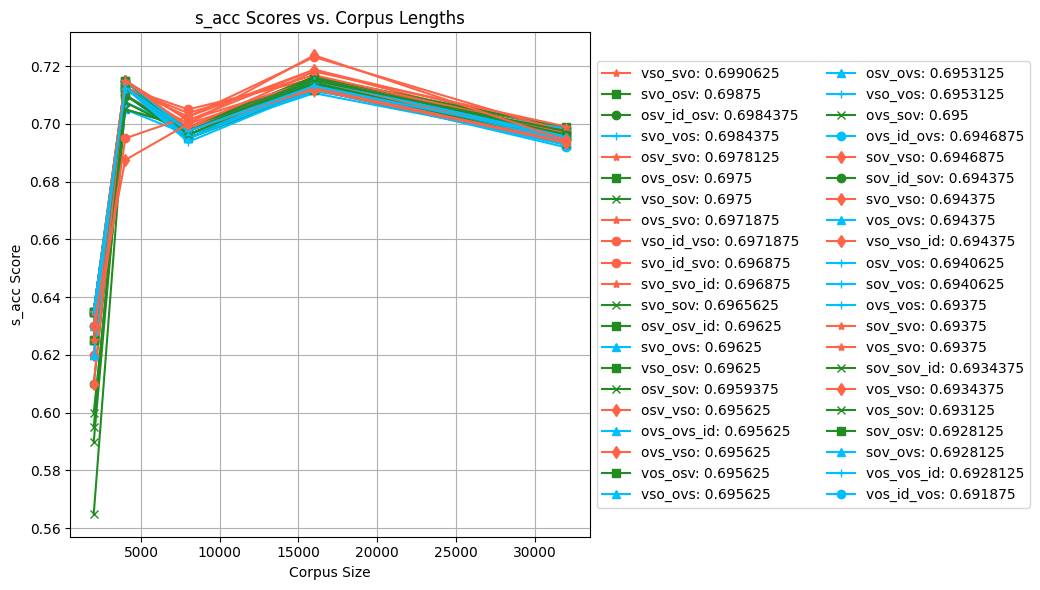

In [7]:
plot_scores(df, 's_acc')

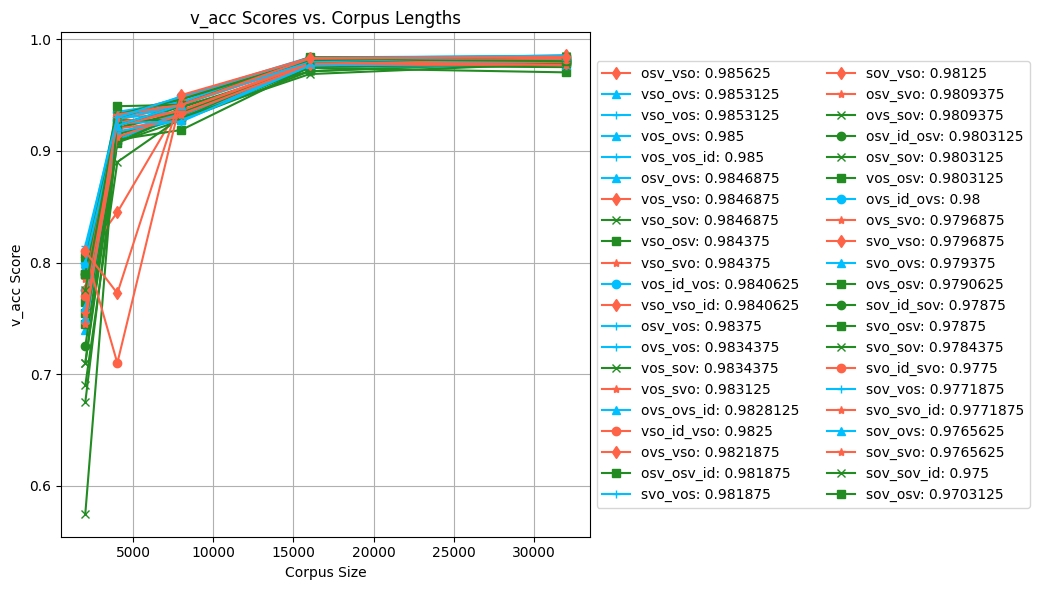

In [8]:
plot_scores(df, 'v_acc')

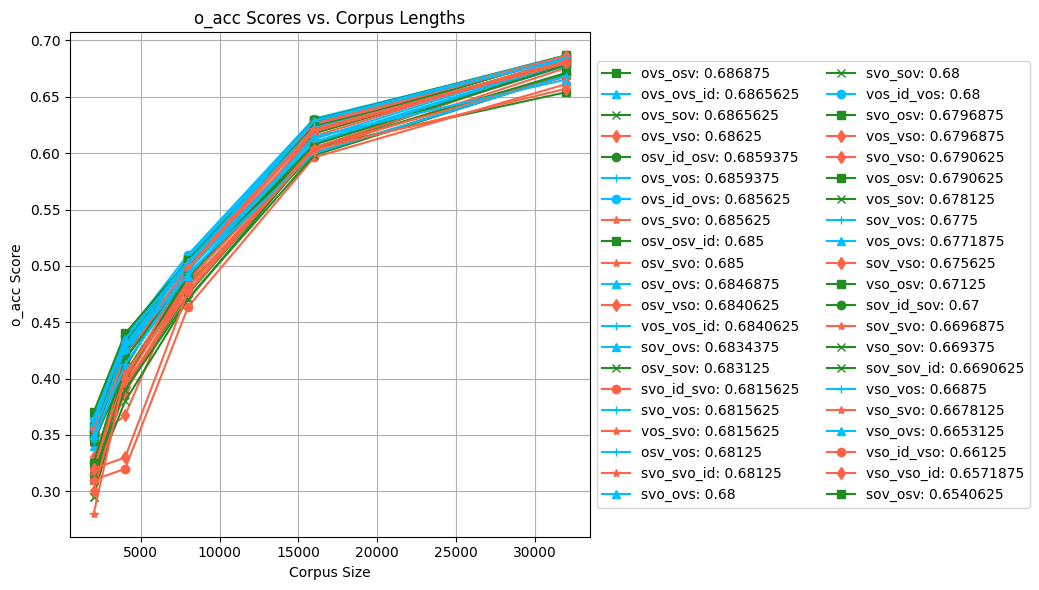

In [9]:
plot_scores(df, 'o_acc')

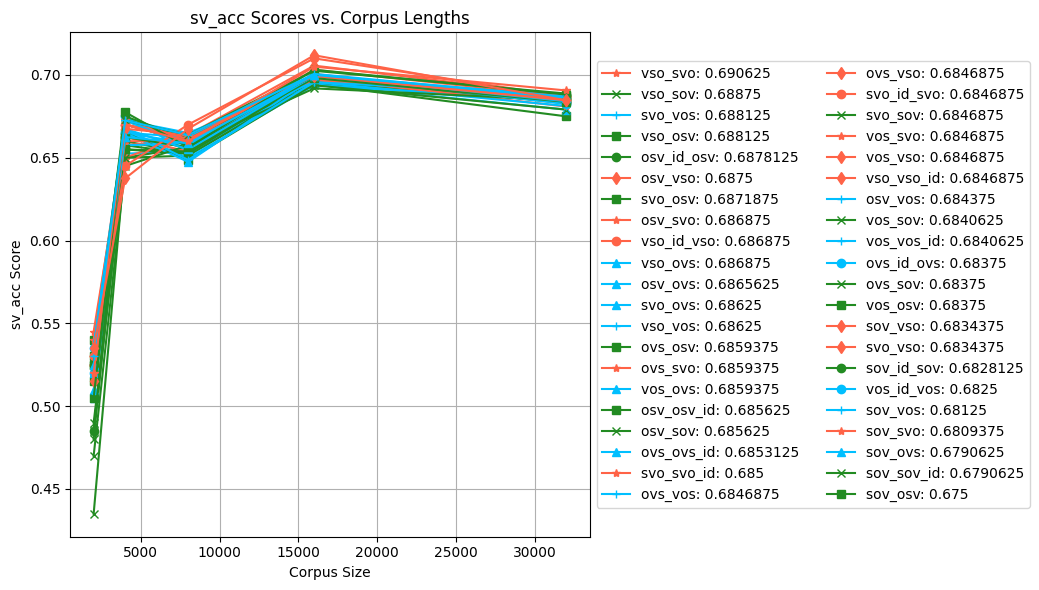

In [10]:
plot_scores(df, 'sv_acc')

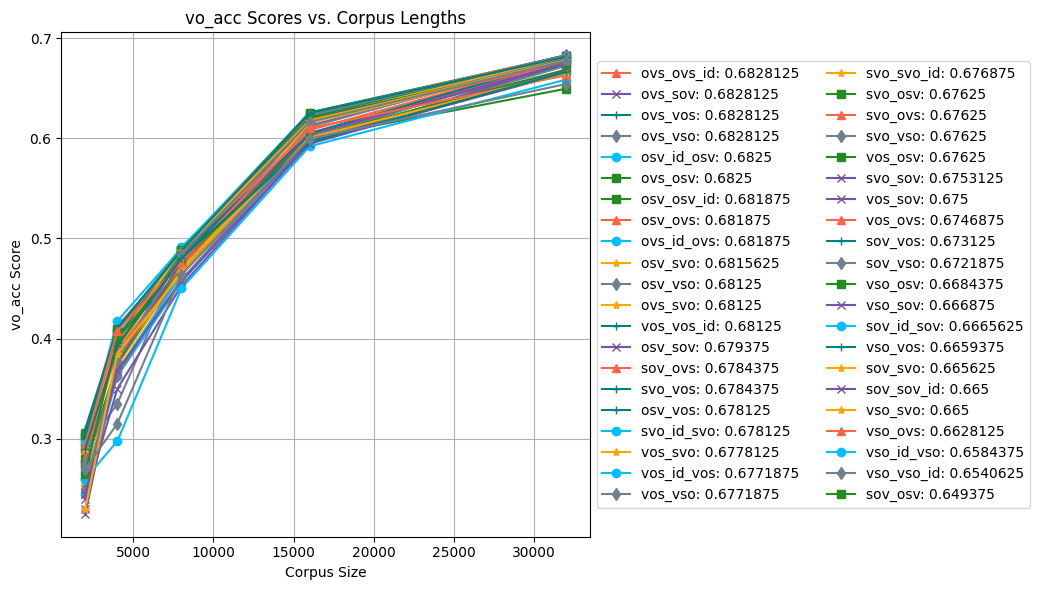

In [56]:
plot_scores(df, 'vo_acc')

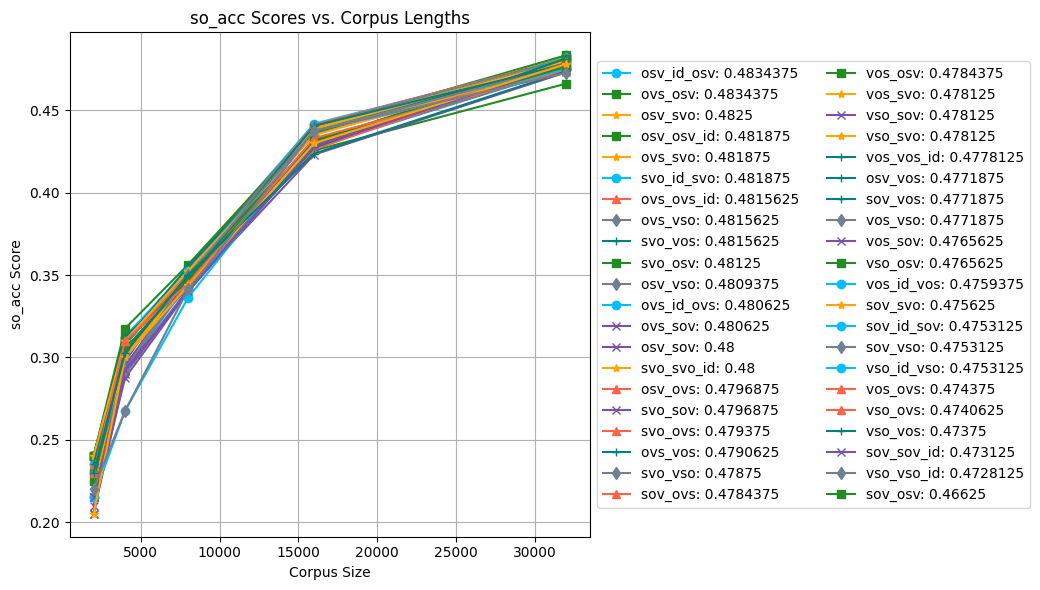

In [57]:
plot_scores(df, 'so_acc')

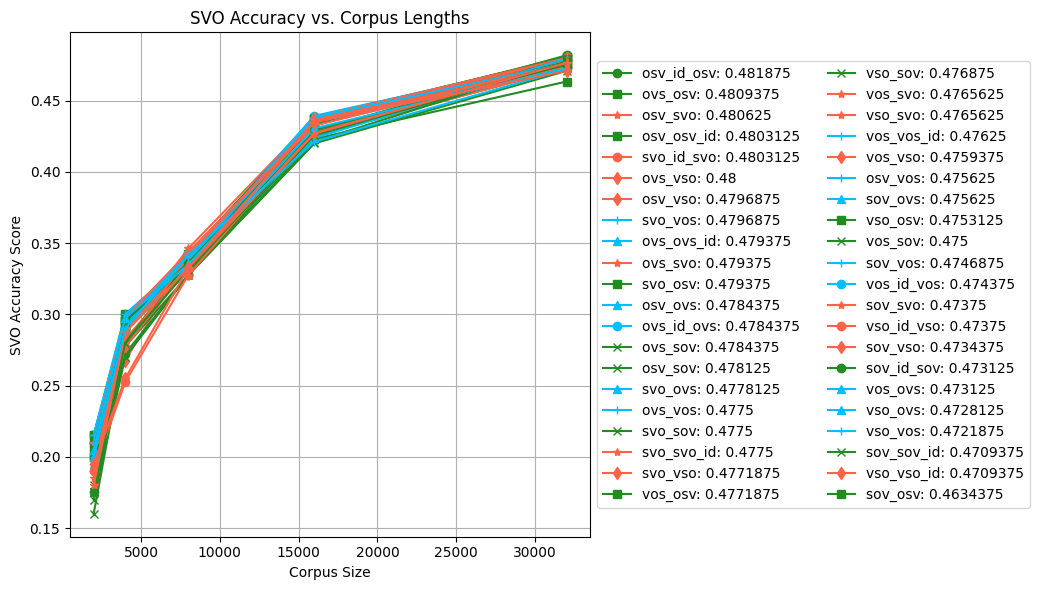

In [14]:
plot_scores(df, 'svo_acc')

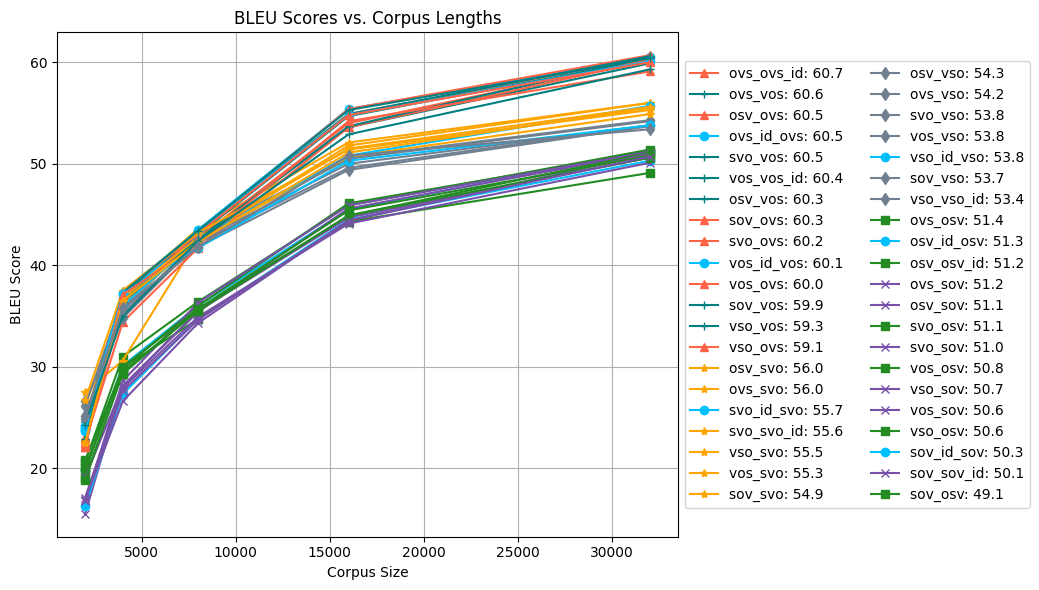

In [59]:
plot_scores(df)

**Analysis:** <br>
- bleu overall is increasing and concave
- as corpus size increases, we converge to 3 groups
- the 3 groups are exactly the last elem of the tgt 


Now let's do an analysis by breaking down into the various corpus lengths.

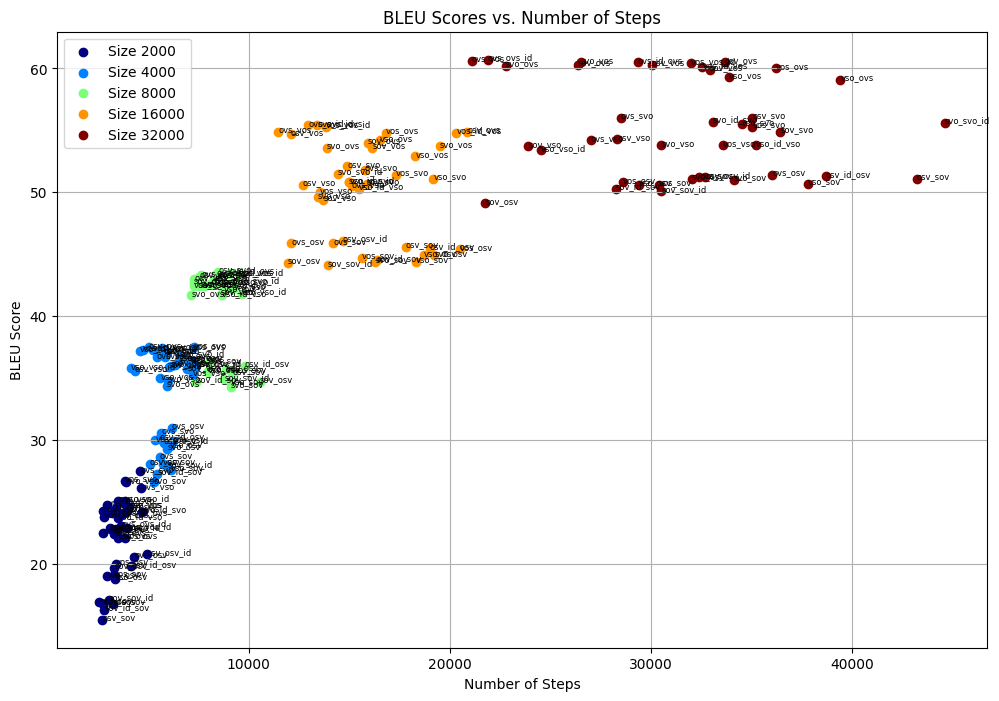

In [34]:
plot_score_vs_steps(df)

**Analysis:**
- Number of steps is not a big deal anymore, i.e. things are prob being trained properly

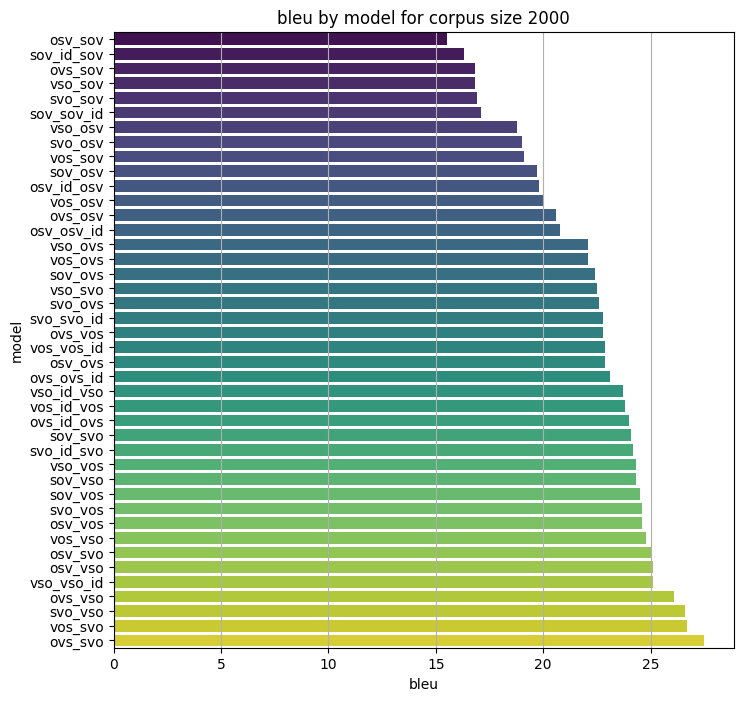

In [35]:
plot_by_len(df, 2000)

In [36]:
df_2k = df[(df['corpus_length'] == 2000) & (df['is_id'] == False)].drop(['normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_2k.head()

src  tgt  bleu  num_steps  s_acc  v_acc  o_acc  sv_acc  vo_acc  so_acc  \
0  SVO  SOV  16.9       2568  0.600  0.690  0.310   0.470   0.240   0.210   
1  SVO  VSO  26.6       3918  0.630  0.790  0.330   0.530   0.275   0.230   
2  SVO  VOS  24.6       4062  0.625  0.795  0.360   0.535   0.300   0.240   
3  SVO  OSV  19.0       2940  0.635  0.745  0.345   0.515   0.275   0.230   
4  SVO  OVS  22.6       3438  0.625  0.750  0.360   0.510   0.290   0.235   

   svo_acc     name  is_id  
0    0.170  svo_sov  False  
1    0.205  svo_vso  False  
2    0.215  svo_vos  False  
3    0.200  svo_osv  False  
4    0.205  svo_ovs  False

In [37]:
df_2k.describe()['bleu']

count    30.000000
mean     22.293333
std       3.282234
min      15.500000
25%      19.775000
50%      22.700000
75%      24.600000
max      27.500000
Name: bleu, dtype: float64

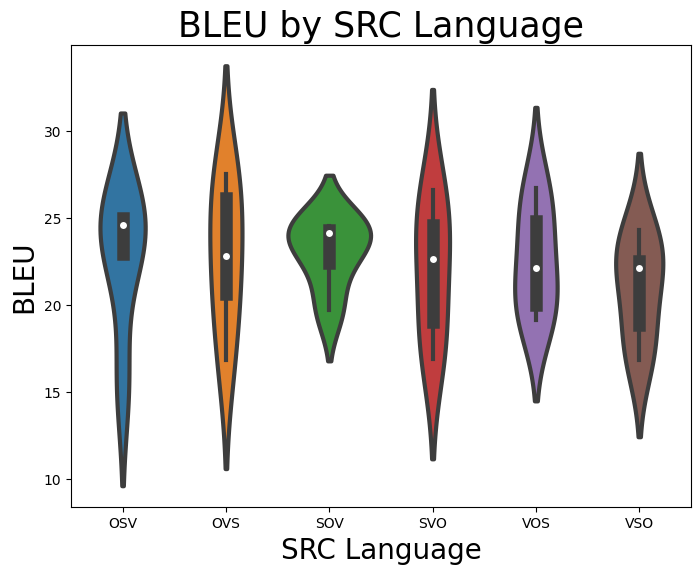

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [38]:
violinplot(df_2k['src'], df_2k['bleu'], xlabel = "SRC Language", ylabel= 'BLEU')

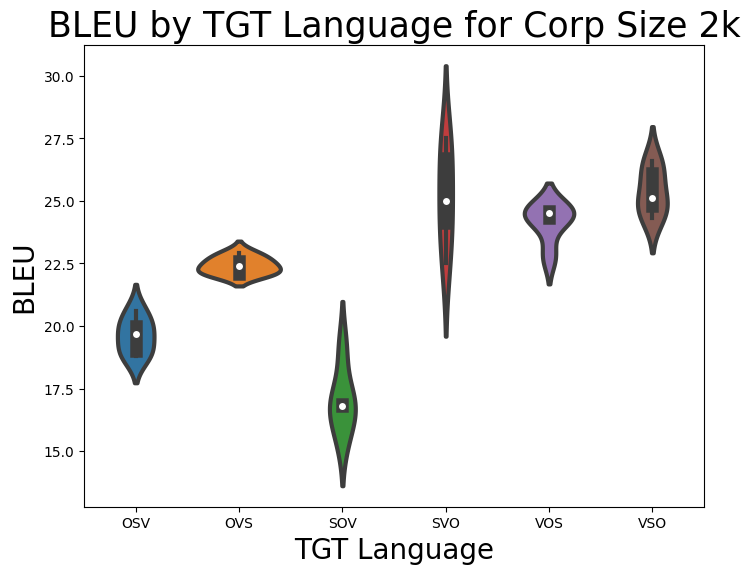

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 2k'}, xlabel='TGT Language', ylabel='BLEU'>

In [39]:
violinplot(df_2k['tgt'], df_2k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 2k')

**Analysis:**
- TGT language seems to be the thing that matters, since the variance in results is less
- SVO, VOS, VSO perform well, then OVS, OSV, SOV


Let's formalize this.

In [40]:
grouped = df_2k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

src   Mean  Range  Variance
0  OSV  22.62    9.6    16.627
1  OVS  22.76   10.7    18.453
2  SOV  23.00    4.8     4.100
3  SVO  21.94    9.7    15.818
4  VOS  22.54    7.6    10.223
5  VSO  20.90    7.5     9.195

In [41]:
grouped = df_2k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values("tgt")

tgt   Mean  Range  Variance
0  OSV  19.62    1.8     0.542
1  OVS  22.42    0.8     0.117
2  SOV  17.02    3.6     1.687
3  SVO  25.16    5.0     4.018
4  VOS  24.16    1.8     0.593
5  VSO  25.38    2.3     0.897

In [42]:
violinplot(df_2k['last'], df_2k['bleu'], xlabel = "last", ylabel='bleu')

KeyError: 'last'

Let's see if these trends persist as we increase corpus length.

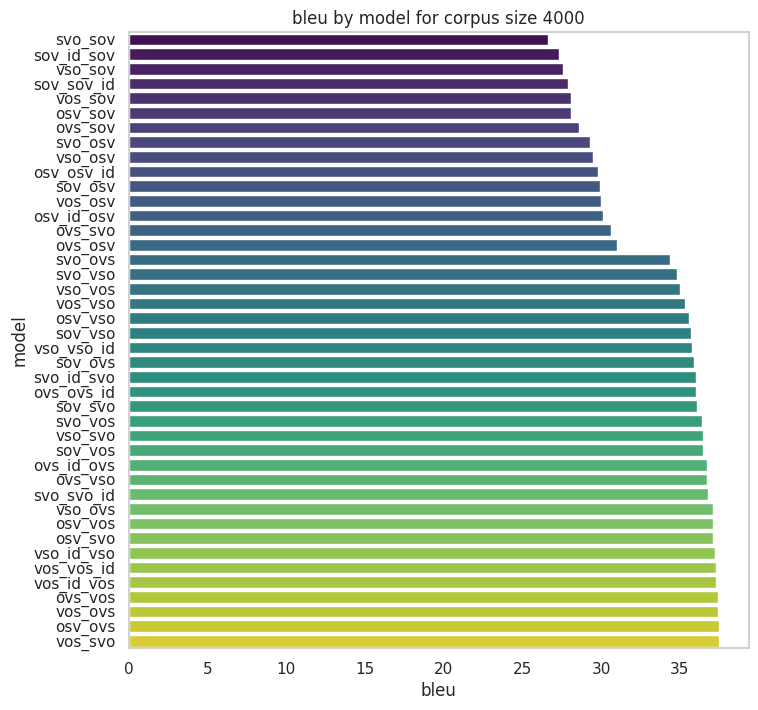

In [ ]:
plot_by_len(df, 4000)

In [ ]:
df_4k = df[(df['corpus_length'] == 4000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_4k.head()

src  tgt  bleu  num_steps     name last
42  SVO  SOV  26.6       5291  svo_sov    V
43  SVO  VSO  34.8       5984  svo_vso    O
44  SVO  VOS  36.4       7172  svo_vos    S
45  SVO  OSV  29.3       5951  svo_osv    V
46  SVO  OVS  34.4       5918  svo_ovs    S

In [ ]:
df_4k.describe()['bleu']

count    30.000000
mean     33.643333
std       3.738678
min      26.600000
25%      29.925000
50%      35.450000
75%      36.650000
max      37.500000
Name: bleu, dtype: float64

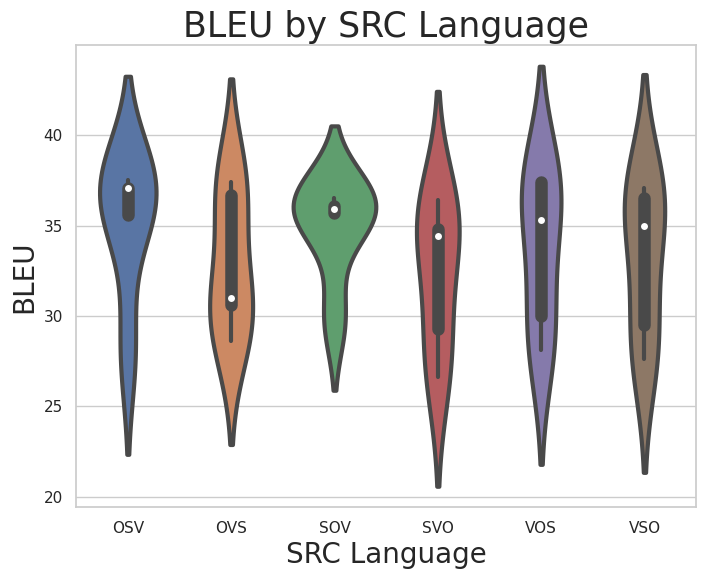

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [ ]:
violinplot(df_4k['src'], df_4k['bleu'], xlabel = "SRC Language", ylabel= 'BLEU')

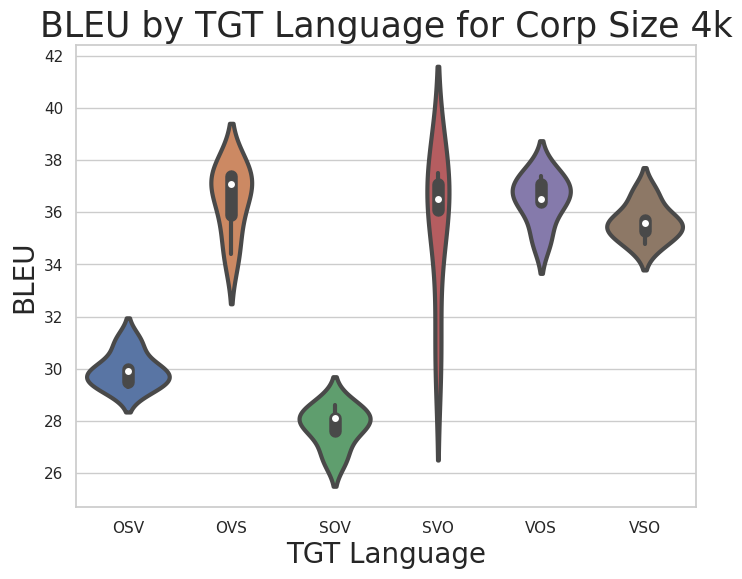

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 4k'}, xlabel='TGT Language', ylabel='BLEU'>

In [ ]:
violinplot(df_4k['tgt'], df_4k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 4k')

**Analysis:**
- This looks remarkably similar
- The general pattern of what does better/worse remains
- SVO still has a decent amount of variance, which is interesting

In [ ]:
grouped = df_4k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

src   Mean  Range  Variance
0  OSV  35.08    9.4    15.752
1  OVS  32.86    8.8    15.518
2  SOV  34.82    6.6     7.652
3  SVO  32.30    9.8    17.240
4  VOS  33.66    9.4    18.933
5  VSO  33.14    9.5    18.593

In [ ]:
grouped = df_4k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

tgt   Mean  Range  Variance
0  OSV  29.94    1.7     0.433
1  OVS  36.46    3.1     1.733
2  SOV  27.80    2.0     0.575
3  SVO  35.56    6.9     7.978
4  VOS  36.48    2.4     0.857
5  VSO  35.62    1.9     0.487

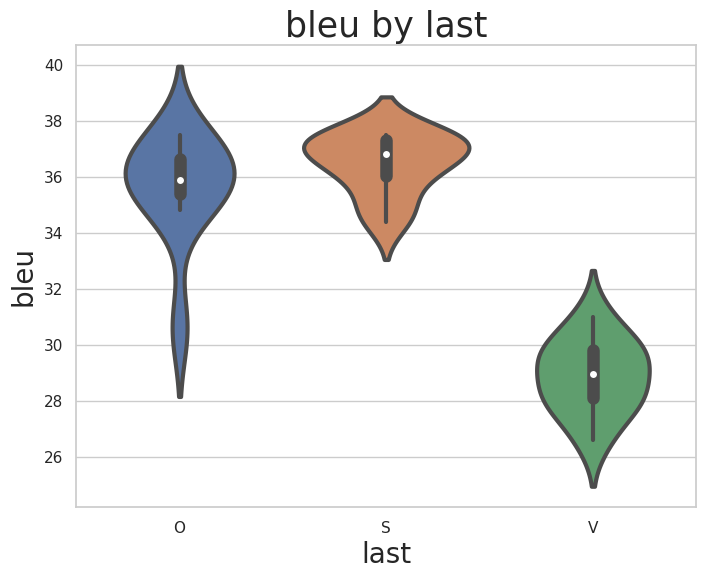

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [ ]:
violinplot(df_4k['last'], df_4k['bleu'], xlabel = "last", ylabel='bleu')

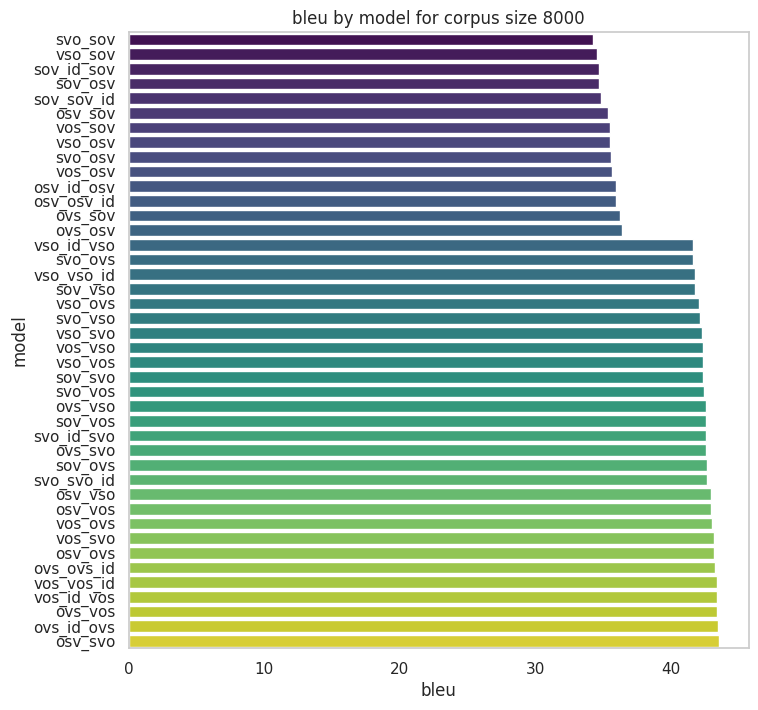

In [ ]:
plot_by_len(df, 8000)

In [ ]:
df_8k = df[(df['corpus_length'] == 8000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_8k.head()

src  tgt  bleu  num_steps     name last
84  SVO  SOV  34.3       9100  svo_sov    V
85  SVO  VSO  42.2       9180  svo_vso    O
86  SVO  VOS  42.5       7620  svo_vos    S
87  SVO  OSV  35.6       7960  svo_osv    V
88  SVO  OVS  41.7       7140  svo_ovs    S

In [ ]:
df_8k.describe()['bleu']

count    30.000000
mean     40.226667
std       3.517144
min      34.300000
25%      35.850000
50%      42.350000
75%      42.675000
max      43.600000
Name: bleu, dtype: float64

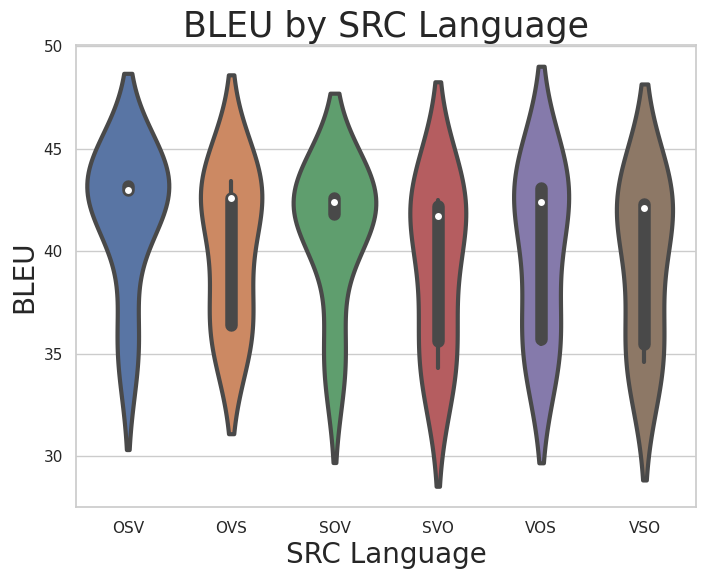

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [ ]:
violinplot(df_8k['src'], df_8k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

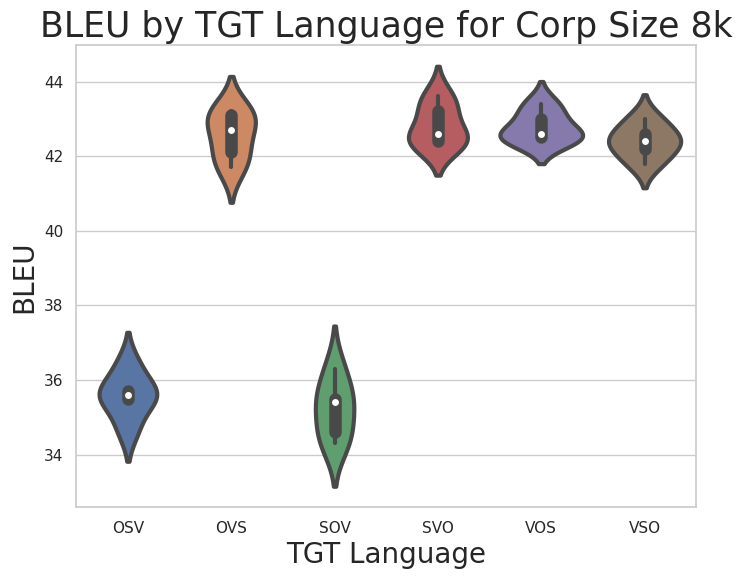

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 8k'}, xlabel='TGT Language', ylabel='BLEU'>

In [ ]:
violinplot(df_8k['tgt'], df_8k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 8k')

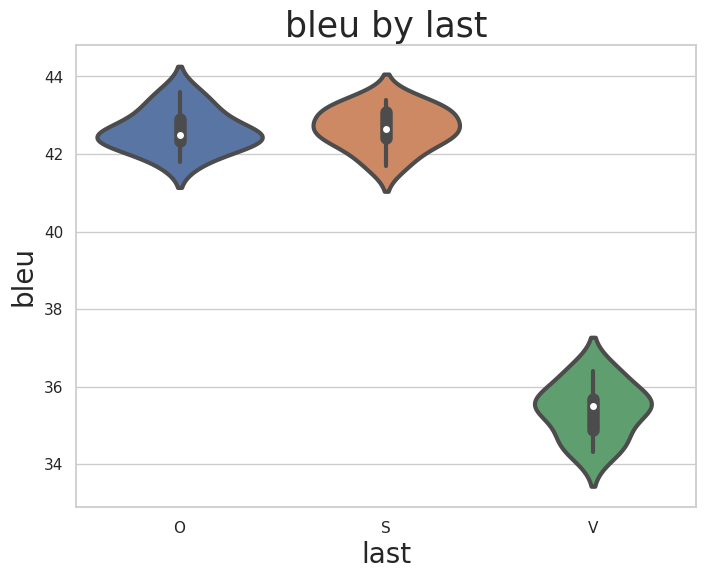

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [ ]:
violinplot(df_8k['last'], df_8k['bleu'], xlabel = "last", ylabel='bleu')

In [ ]:
grouped = df_8k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

src   Mean  Range  Variance
0  OSV  41.64    8.2    12.228
1  OVS  40.26    7.1    12.848
2  SOV  40.84    8.0    11.903
3  SVO  39.26    8.2    15.773
4  VOS  39.98    7.7    16.087
5  VSO  39.38    7.8    15.737

In [ ]:
grouped = df_8k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

tgt   Mean  Range  Variance
0  OSV  35.58    1.7     0.367
1  OVS  42.56    1.5     0.418
2  SOV  35.22    2.0     0.627
3  SVO  42.82    1.3     0.312
4  VOS  42.78    1.0     0.172
5  VSO  42.40    1.2     0.200

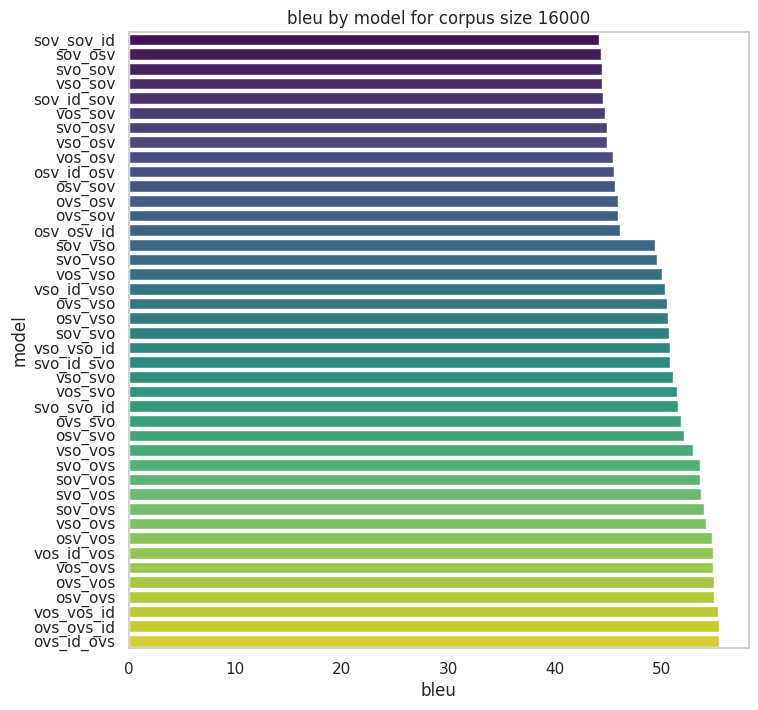

In [ ]:
plot_by_len(df, 16000)

In [ ]:
df_16k = df[(df['corpus_length'] == 16000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'chrF2', 'corpus_length'], axis=1)

df_16k.head()

src  tgt  bleu  num_steps     name last
126  SVO  SOV  44.4      16302  svo_sov    V
127  SVO  VSO  49.6      13452  svo_vso    O
128  SVO  VOS  53.7      19494  svo_vos    S
129  SVO  OSV  44.9      19228  svo_osv    V
130  SVO  OVS  53.6      13884  svo_ovs    S

In [ ]:
df_16k.describe()['bleu']

count    30.000000
mean     49.963333
std       3.880409
min      44.300000
25%      45.675000
50%      50.650000
75%      53.600000
max      54.900000
Name: bleu, dtype: float64

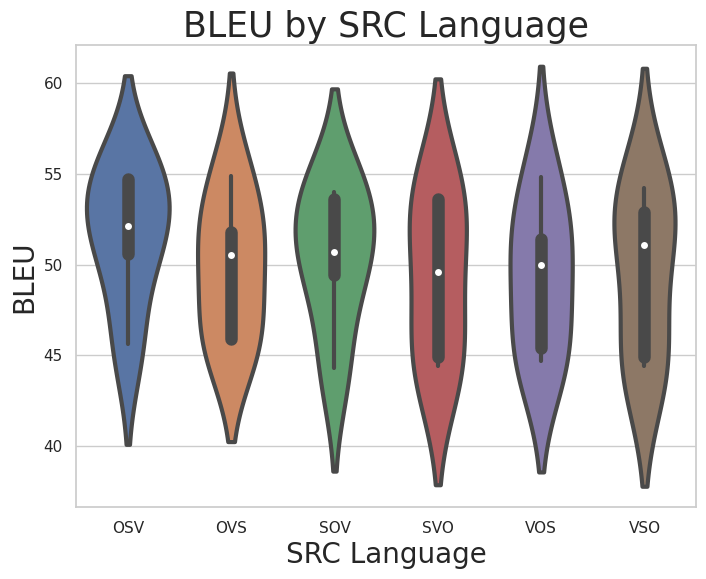

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [ ]:
violinplot(df_16k['src'], df_16k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

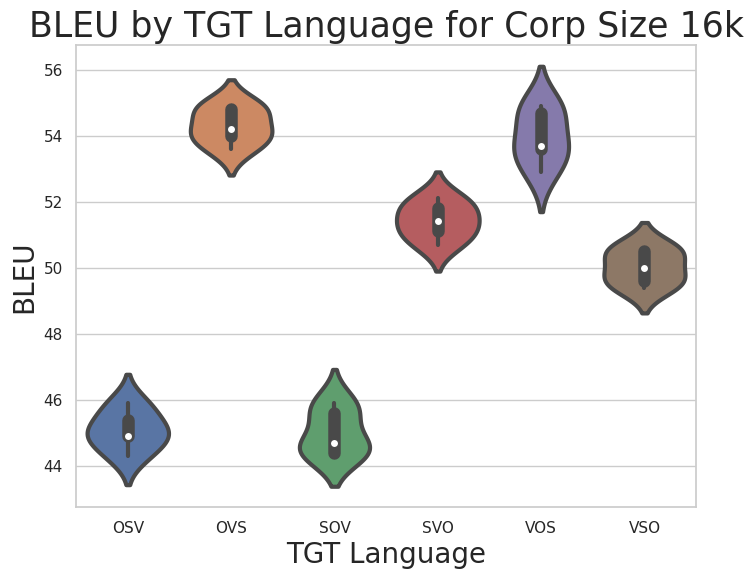

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 16k'}, xlabel='TGT Language', ylabel='BLEU'>

In [ ]:
violinplot(df_16k['tgt'], df_16k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 16k')

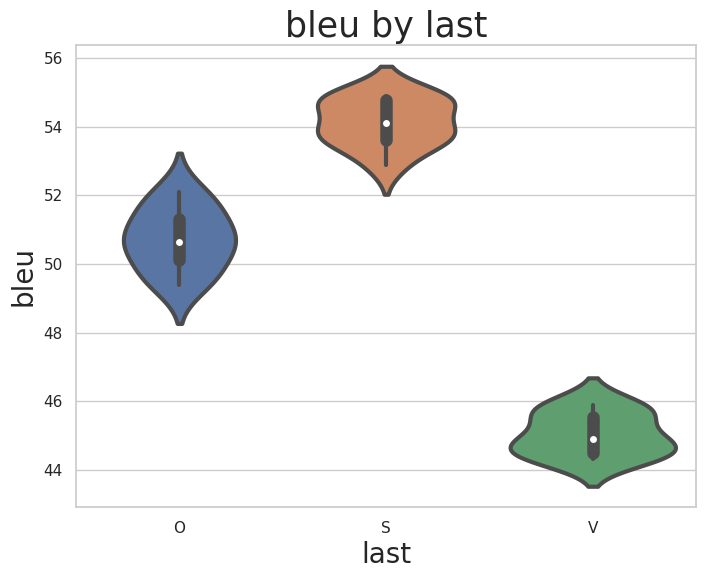

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [ ]:
violinplot(df_16k['last'], df_16k['bleu'], xlabel = "last", ylabel='bleu')

In [ ]:
grouped = df_16k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

src   Mean  Range  Variance
0  OSV  51.58    9.3    14.437
1  OVS  49.80    9.0    15.230
2  SOV  50.40    9.7    15.375
3  SVO  49.24    9.3    20.323
4  VOS  49.26   10.1    17.878
5  VSO  49.50    9.8    20.845

In [ ]:
grouped = df_16k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

tgt   Mean  Range  Variance
0  OSV  45.08    1.6     0.362
1  OVS  54.30    1.3     0.300
2  SOV  45.00    1.5     0.495
3  SVO  51.42    1.4     0.307
4  VOS  53.96    2.0     0.688
5  VSO  50.02    1.2     0.282

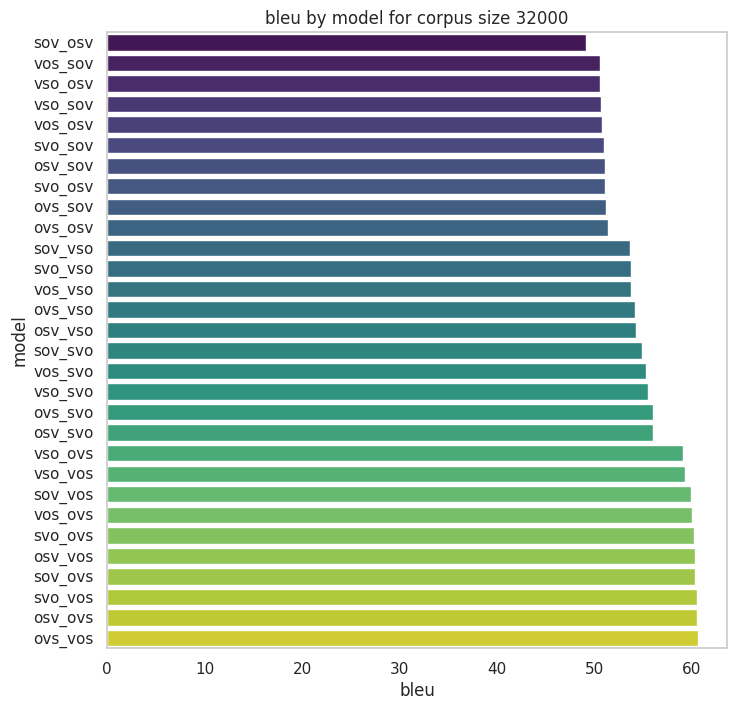

In [ ]:
plot_by_len(df, 32000)

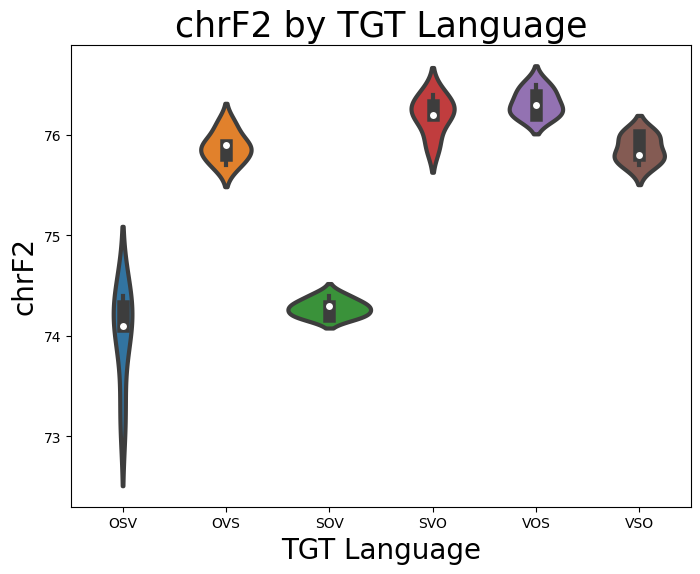

<Axes: title={'center': 'chrF2 by TGT Language'}, xlabel='TGT Language', ylabel='chrF2'>

In [ ]:
violinplot(df_32k['tgt'], df_32k['chrF2'], xlabel = 'TGT Language', ylabel = "chrF2")

In [ ]:
df_32k = df[(df['corpus_length'] == 32000) & (df['is_id'] == False)].drop(['is_id', 'normalized_steps', 'corpus_length'], axis=1)

df_32k.head()

src  tgt  bleu  chrF2  num_steps     name last
168  SVO  SOV  51.0   74.3      34114  svo_sov    V
169  SVO  VSO  53.8   75.8      30514  svo_vso    O
170  SVO  VOS  60.5   76.5      26499  svo_vos    S
171  SVO  OSV  51.1   74.3      32047  svo_osv    V
172  SVO  OVS  60.2   75.9      22792  svo_ovs    S

In [ ]:
df_32k.describe()['bleu']

count    30.000000
mean     55.193333
std       3.938312
min      49.100000
25%      51.125000
50%      54.600000
75%      59.750000
max      60.600000
Name: bleu, dtype: float64

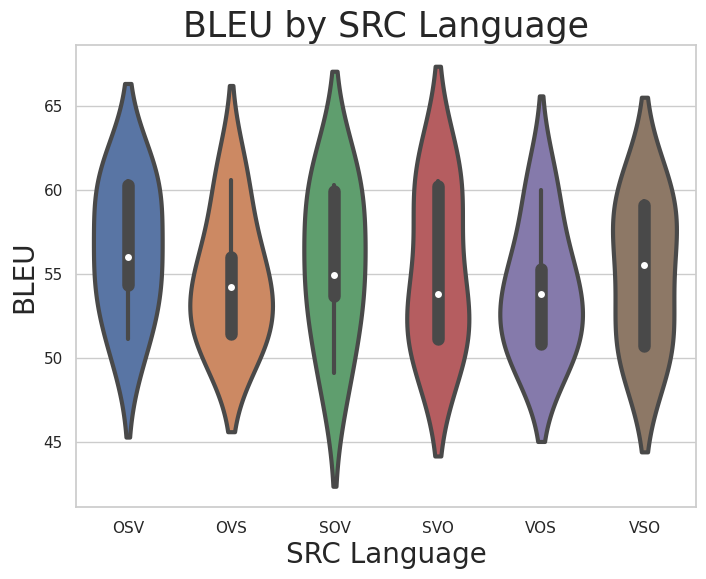

<Axes: title={'center': 'BLEU by SRC Language'}, xlabel='SRC Language', ylabel='BLEU'>

In [ ]:
violinplot(df_32k['src'], df_32k['bleu'], xlabel = 'SRC Language', ylabel = "BLEU")

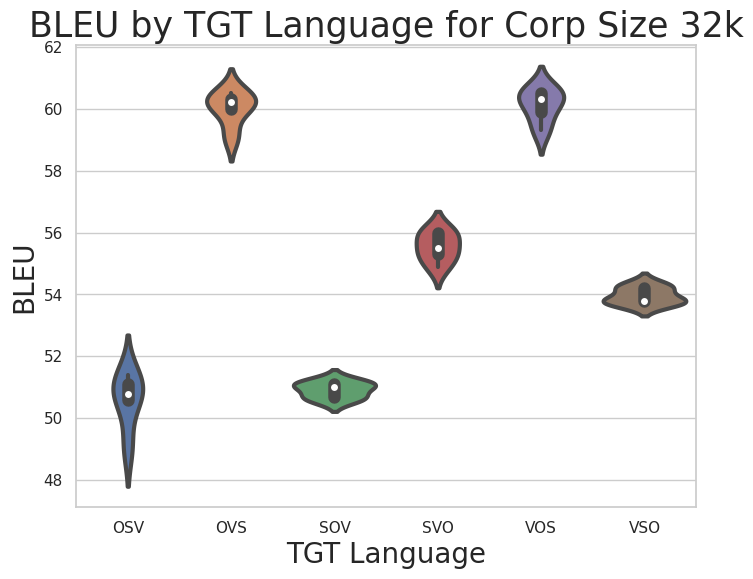

<Axes: title={'center': 'BLEU by TGT Language for Corp Size 32k'}, xlabel='TGT Language', ylabel='BLEU'>

In [ ]:
violinplot(df_32k['tgt'], df_32k['bleu'], xlabel = "TGT Language", ylabel= 'BLEU', title = 'BLEU by TGT Language for Corp Size 32k')

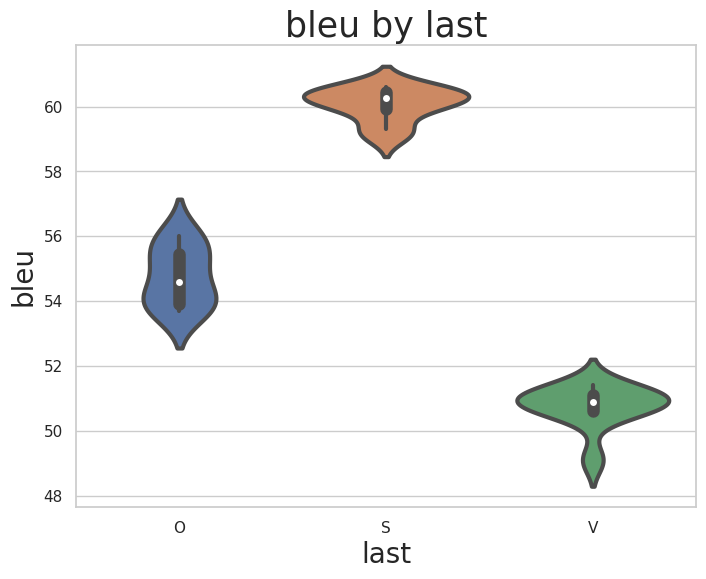

<Axes: title={'center': 'bleu by last'}, xlabel='last', ylabel='bleu'>

In [ ]:
violinplot(df_32k['last'], df_32k['bleu'], xlabel = "last", ylabel='bleu')

In [ ]:
grouped = df_32k.groupby('src')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('src')

src   Mean  Range  Variance
0  OSV  56.44    9.4    16.168
1  OVS  54.68    9.4    14.972
2  SOV  55.58   11.2    21.732
3  SVO  55.32    9.5    22.357
4  VOS  54.10    9.4    14.870
5  VSO  55.04    8.7    18.348

In [ ]:
grouped = df_32k.groupby('tgt')['bleu'].agg(
    Mean='mean',
    Range=lambda x: x.max() - x.min(),
    Variance='var'
)

grouped.reset_index().sort_values('tgt')

tgt   Mean  Range  Variance
0  OSV  50.60    2.3     0.795
1  OVS  60.02    1.4     0.297
2  SOV  50.92    0.6     0.067
3  SVO  55.54    1.1     0.223
4  VOS  60.12    1.3     0.282
5  VSO  53.96    0.6     0.073

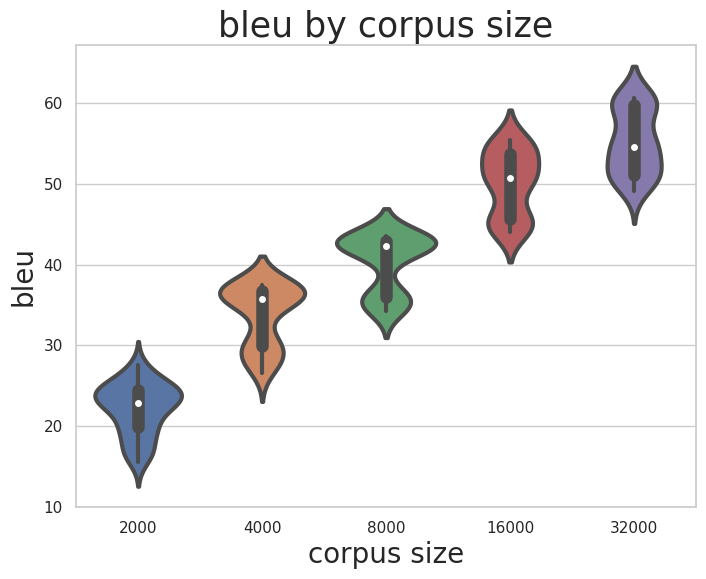

<Axes: title={'center': 'bleu by corpus size'}, xlabel='corpus size', ylabel='bleu'>

In [ ]:
violinplot(df['corpus_length'], df['bleu'], xlabel='corpus size', ylabel='bleu')

**Analysis:**
- Clearly corpus size helps
- The distribution within each is bimodal (since 4 good 2 bad type of deal)

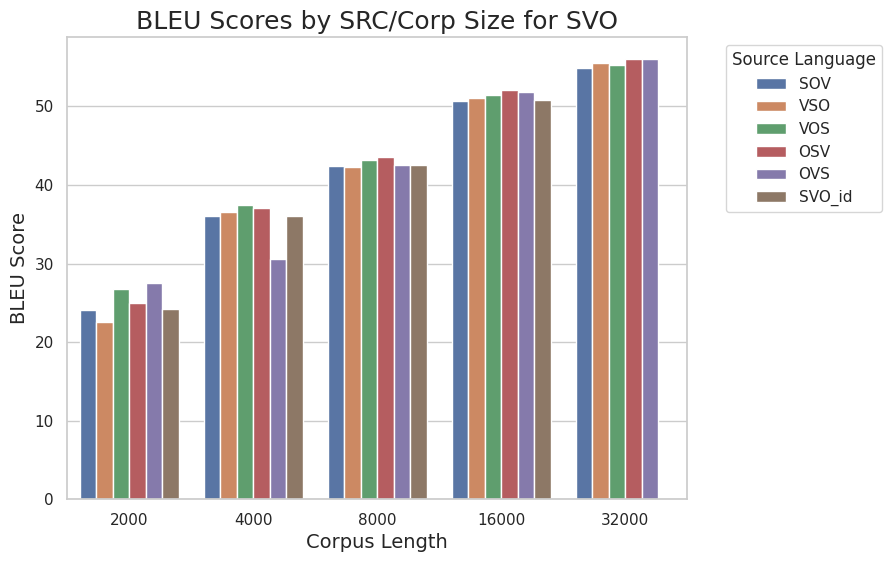

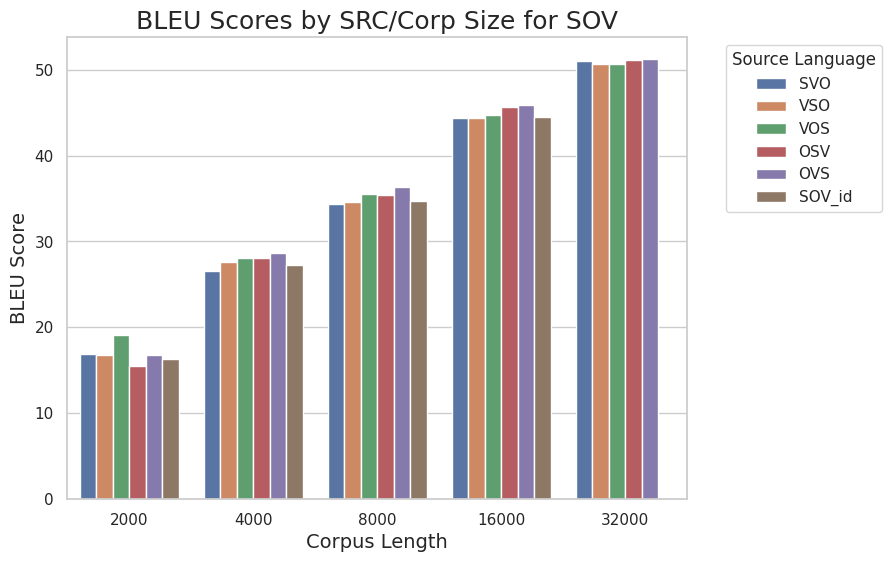

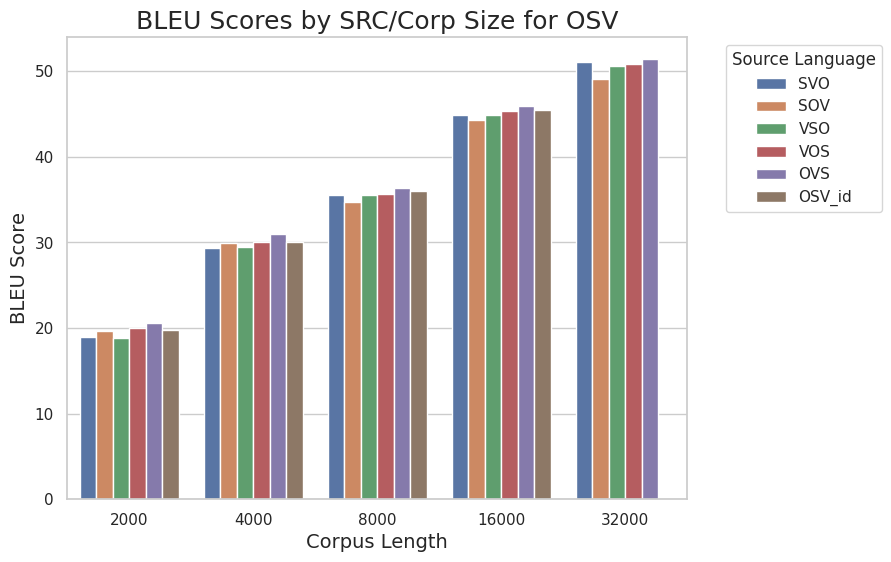

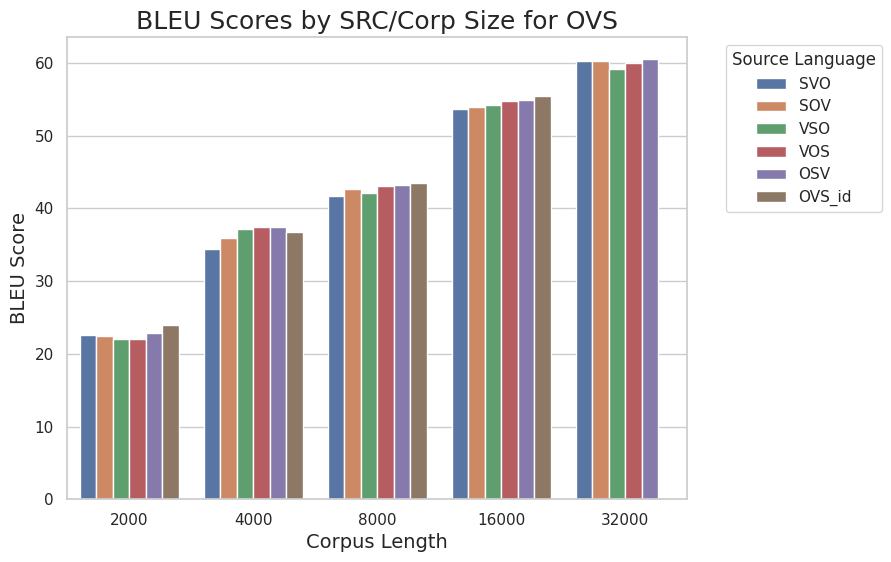

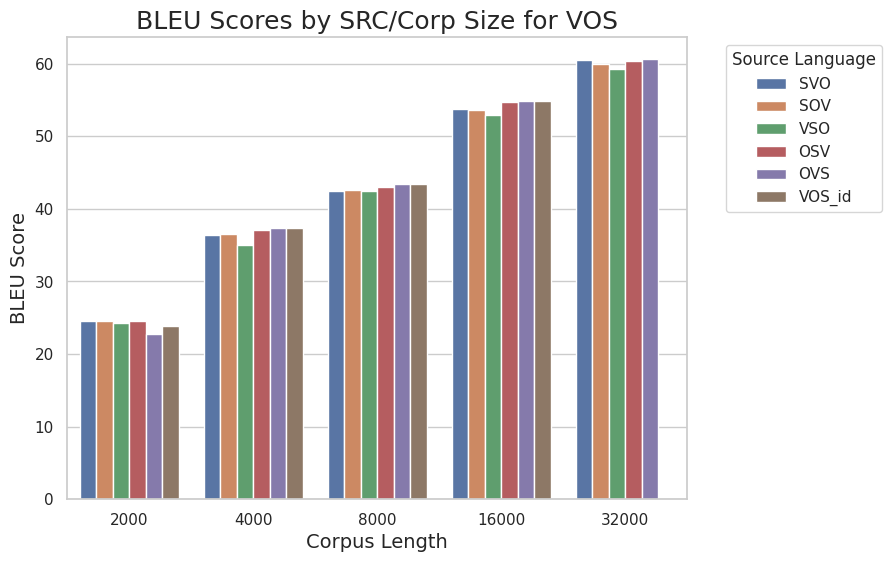

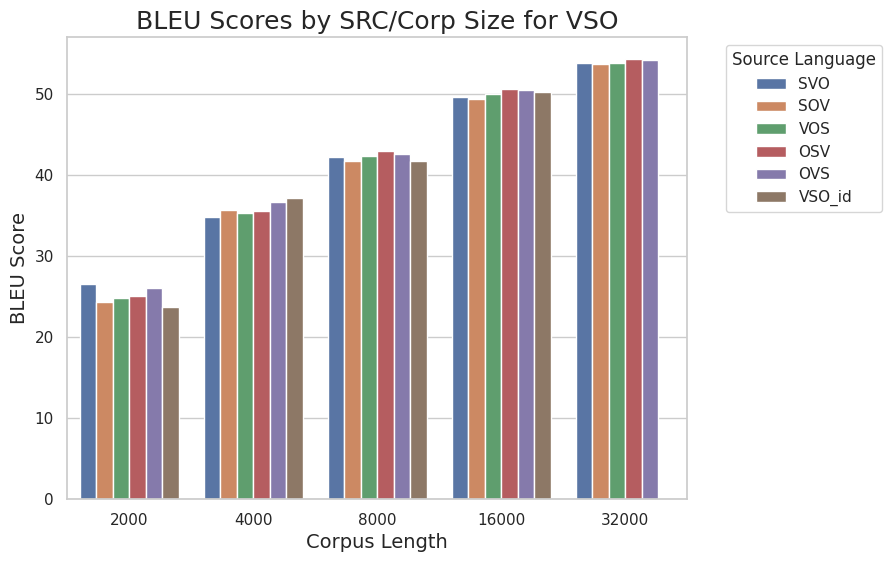

In [ ]:
for perm in ['SVO', "SOV", "OSV", "OVS", "VOS", "VSO"]:
    two_factor_plot(df, perm)

<a id='3'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> Data Variability Analysis </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the data variability experiment, we are investigating the variability of results. We generated 5 testperanto SVO datasets of size 2000 in parallel (so different voicebox but same language) and trained pairwise 2 (5C2) = 20 models. In theory, the BLEU should be very similar, but this is just to give us some clarity on whether or not that's actually true.
</p>

In [ ]:
df = get_data('data_variability')

df.head()

corpus_length   src   tgt  bleu  chrF2  num_steps       name  is_id  \
0           2000  SVO1  SVO2  24.6   58.0       3270  svo1_svo2  False   
1           2000  SVO1  SVO3  26.9   59.2       3624  svo1_svo3  False   
2           2000  SVO1  SVO4  26.6   59.4       5340  svo1_svo4  False   
3           2000  SVO1  SVO5  26.0   59.5       4296  svo1_svo5  False   
4           2000  SVO2  SVO3  24.9   58.1       3144  svo2_svo3  False   

   normalized_steps  
0             1.635  
1             1.812  
2             2.670  
3             2.148  
4             1.572

: 

: 

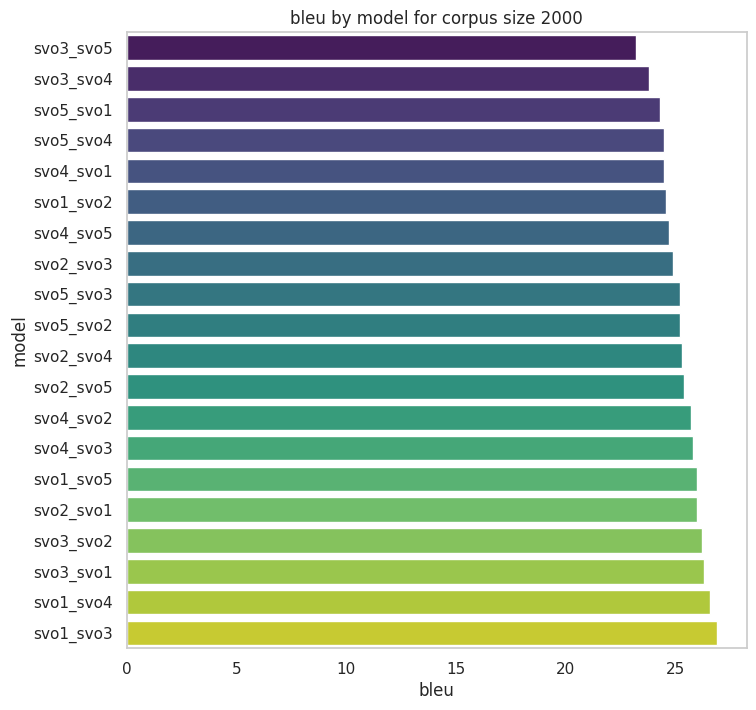

: 

: 

In [ ]:
plot_by_len(df, 2000)

**Analysis:**
- The variability here is much lower.

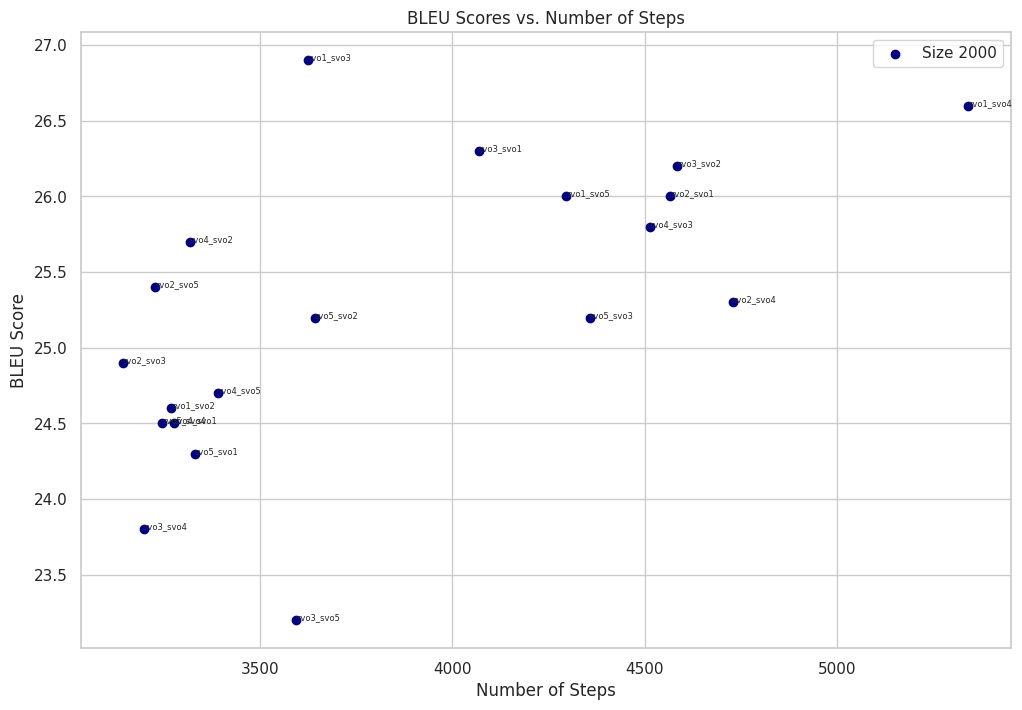

: 

: 

In [ ]:
plot_score_vs_steps(df)

<a id='4'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> No Pronouns Experiment </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the no pronouns experiment, we are investigating the performance of models trained on data with no pronouns. We generated datasets from SVO to all 6 permutations for corpus sizes ranging from 2000 to 32000 (doubling in size). In total there are 6 * 5 = 30 models.  
</p>

In [60]:
df = get_data('no_pro')
df.head()

corpus_length  src     tgt  bleu  chrF2  num_steps  s_acc  v_acc  o_acc  \
0           1000  SVO  SVO_id   2.9   42.9       2812    0.0   0.68   0.15   
1           1000  SVO     SOV   0.0   41.4       2064    0.0   0.70   0.14   
2           1000  SVO     VSO   0.3    6.5        540    0.0   0.02   0.00   
3           1000  SVO     VOS   0.3    7.4        528    0.0   0.02   0.00   
4           1000  SVO     OSV   1.4   40.3       2444    0.0   0.73   0.15   

   sv_acc  vo_acc  so_acc  svo_acc        name  is_id  normalized_steps  
0     0.0    0.15     0.0      0.0  svo_svo_id   True             2.812  
1     0.0    0.14     0.0      0.0     svo_sov  False             2.064  
2     0.0    0.00     0.0      0.0     svo_vso  False             0.540  
3     0.0    0.00     0.0      0.0     svo_vos  False             0.528  
4     0.0    0.15     0.0      0.0     svo_osv  False             2.444

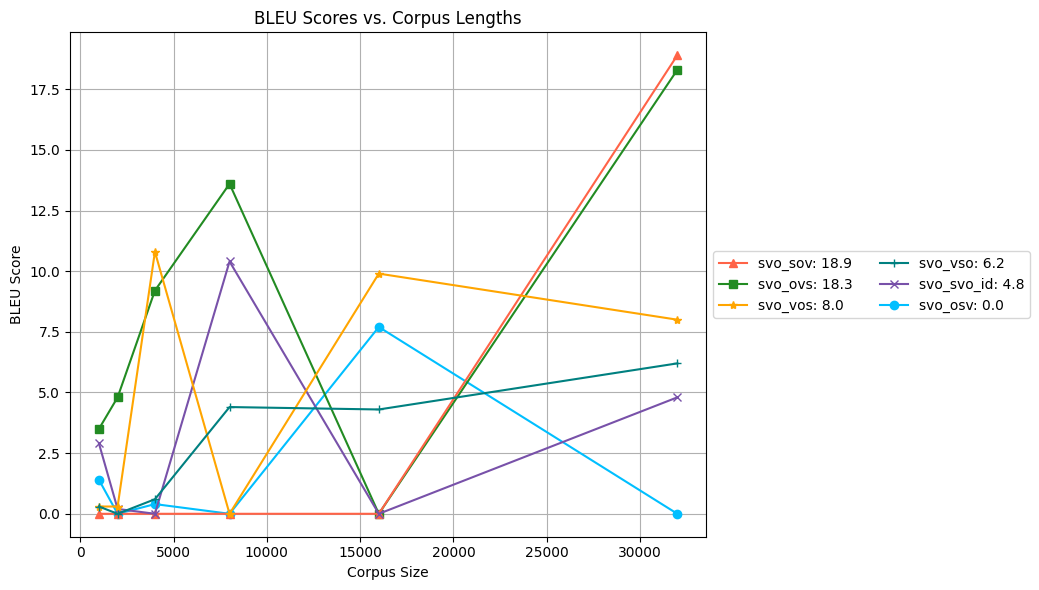

In [ ]:
plot_scores(df)

**Analysis:**
- it seems pronouns were critical and that learinng translations is really hard without them

<a id='5'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> No Pronouns/Articles Experiment </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the no pronouns/articles experiment, we are investigating if articles were importat to translatability. We generated the same as the no pronouns experiment but just added in articles "a"/"the".  
</p>

In [ ]:
#df = get_data('no_pro1')
#df.head()

<a id='6'></a>

# <p style ="padding: 8px; background: linear-gradient(45deg, #000000, #ad5aff); color : #F8F8FF; font-family: Arial, sans-serif; font-size: 70%; text-align: center; border-radius: 20px; margin-top: 15px; box-shadow: 3px 3px 10px rgba(0,0,0,0.1); border: 2px solid #333;"> <strong> No Dependencies Experiment </strong> </p>

<p style = "text-align: justify; font-family: 'Georgia', serif; font-size: 110%; margin: 20px; border: 2px solid #333; padding: 10px; border-radius: 15px;">
In the no dependencies, we generate nouns unconditioned on the verb. Theoretically shutting down this avenue of communication should make position somewhat arbitrary, meaning there shouldn't be differences between different languages.
</p>

In [62]:
df = get_data('no_dep')
df.head()

corpus_length  src     tgt  bleu  chrF2  num_steps  s_acc  v_acc  o_acc  \
0           1000  SVO  SVO_id  21.4   55.2       2364   0.74   0.68   0.34   
1           1000  SVO     SOV   4.7    6.4        399   0.03   0.00   0.00   
2           1000  SVO     VSO  19.6   52.5       1365   0.67   0.57   0.25   
3           1000  SVO     VOS  21.4   58.0       2319   0.73   0.70   0.38   
4           1000  SVO     OSV  15.7   53.1       2565   0.73   0.67   0.40   

   sv_acc  vo_acc  so_acc  svo_acc        name  is_id  normalized_steps  
0    0.52    0.22    0.28     0.19  svo_svo_id   True             2.364  
1    0.00    0.00    0.00     0.00     svo_sov  False             0.399  
2    0.46    0.17    0.20     0.16     svo_vso  False             1.365  
3    0.52    0.27    0.29     0.21     svo_vos  False             2.319  
4    0.53    0.25    0.29     0.19     svo_osv  False             2.565

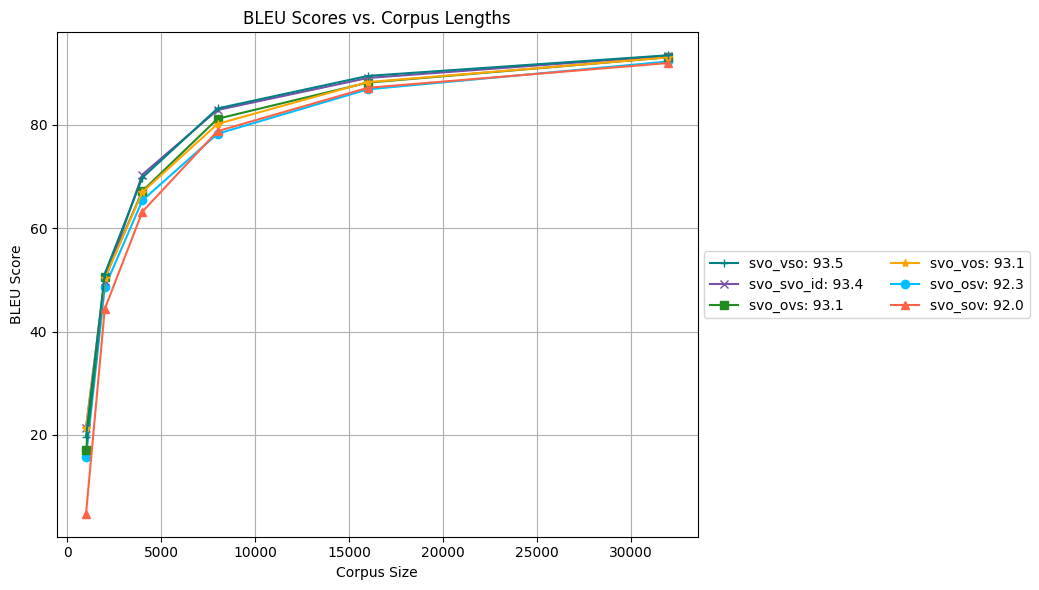

In [ ]:
plot_scores(df)

**Analysis:**
- There's still similar behavior as before, but at a much smaller scale
- Curiously, the bleu is highest out of anywhere i this situation.